# Predicting chance of shooting a goal by players

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math

from matplotlib import pyplot as plt

from utils import create_dummy_df
from utils import run_logistic_regression
from utils import run_lightgbm_classifier

from utils import plot_correlation_matrix
from utils import calculate_confusion_matrix

sns.set()

In [117]:
df_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_player.drop_duplicates(inplace=True)

In [118]:
df_skater = df_player[df_player.playerType.isin(['Shooter', 'Scorer'])].copy()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.drop(columns=['game_id', 'playerType'], inplace=True)

df_goalie = df_player[df_player.playerType.isin(['Goalie'])].copy()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.drop(columns=['game_id', 'playerType'], inplace=True)

In [119]:
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.drop_duplicates(inplace=True)

In [165]:
df = df_game_plays.merge(df_skater, how='left', on='play_id')
df = df.merge(df_goalie, how='left', on='play_id')

In [166]:
#df.head()

## Selecting data to be used for the firt model and making it applicable (dropping nan, resolving categorical features)

In [167]:
# select columns, drop nans
df = df[['play_id', 'event', 'secondaryType', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id', 'goalie_id']][(df.event=='Goal') | (df.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

In [168]:
# prepare target column
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)

In [169]:
##################################################

In [170]:
################################################

In [171]:
# categorical data
cat_var_cols = ['secondaryType']
df = create_dummy_df(df=df, cat_cols=cat_var_cols, dummy_na=True)
df.drop(columns=['secondaryType_nan'], inplace=True)

In [172]:
# balance target (goal)
# taking all goals and a sample with the same size from shot without a goal

goals = df[df.goal==1]
no_goals = df[df.goal==0].sample(goals.shape[0], replace=False)
df = pd.concat([goals, no_goals])

In [173]:
# calculating distance from the goal
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)
#    return math.hypot(middle_goal_x - math.fabs(df.st_x), middle_goal_y - math.fabs(df.st_y))

df['distance'] = df.apply(dist, axis=1)

In [174]:
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df['angle'] = df.apply(angle, axis=1)

<AxesSubplot:>

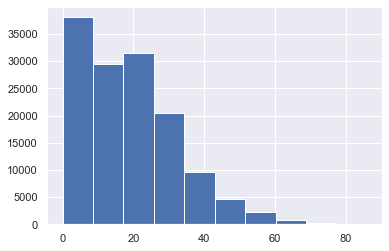

In [175]:
df.angle.hist()

In [177]:
df = df[df.angle<50]

<AxesSubplot:>

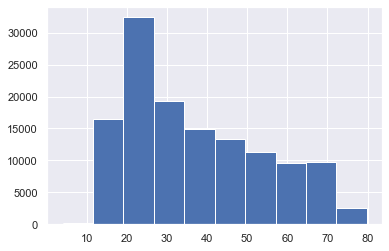

In [178]:
df.distance.hist()

In [179]:
df = df[df.distance<80]

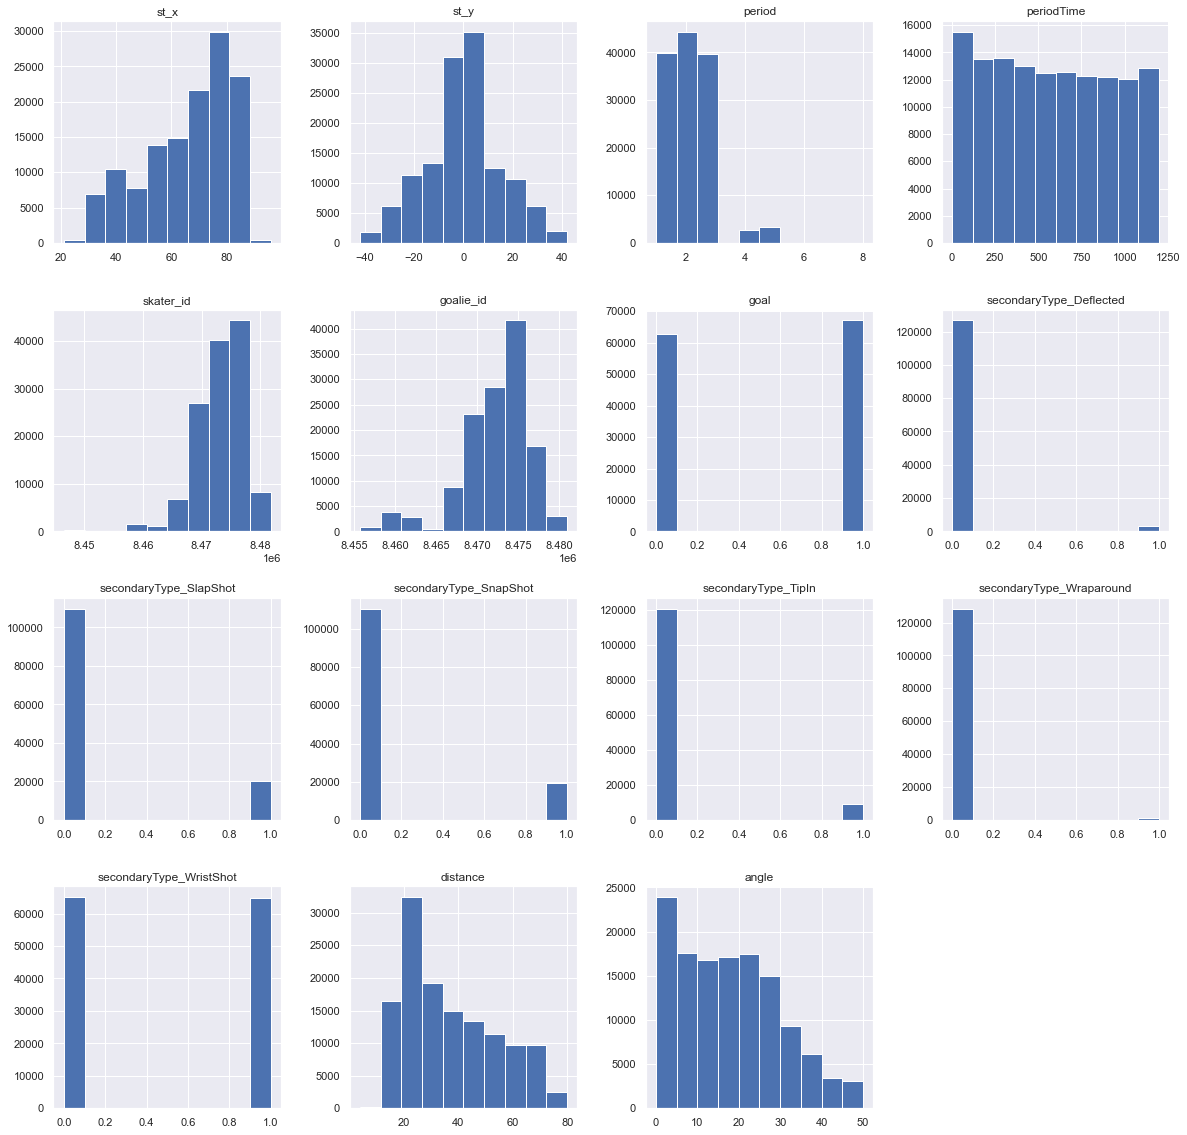

In [180]:
df.hist(figsize=(20, 20));

## Using this features in the first version of the model with no feature engineering yet.

In [181]:
df.columns

Index(['play_id', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id',
       'goalie_id', 'goal', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle'],
      dtype='object')

In [187]:
features = ['st_x', 'st_y', 'period', 'periodTime', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle', 'skater_id', 'goalie_id']

#features = ['distance']

target = 'goal'

In [188]:
# function implemented in the utils.py
model, X_test, y_test  = run_logistic_regression(df, features, target)

Training ran in 0.04093 seconds
Score: 0.5195021811649987
F1 Score: 0.68


In [189]:
# function implemented in the utils.py
model, X_test, y_test = run_lightgbm_classifier(df, features, target)

Training ran in 0.18129 seconds
Score: 0.6822427508339749
F1 Score: 0.71


F1 Score: 0.71


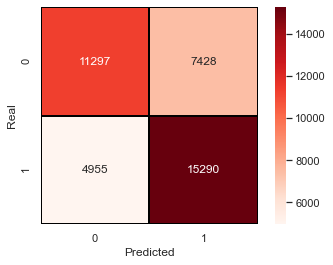

In [190]:
calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);

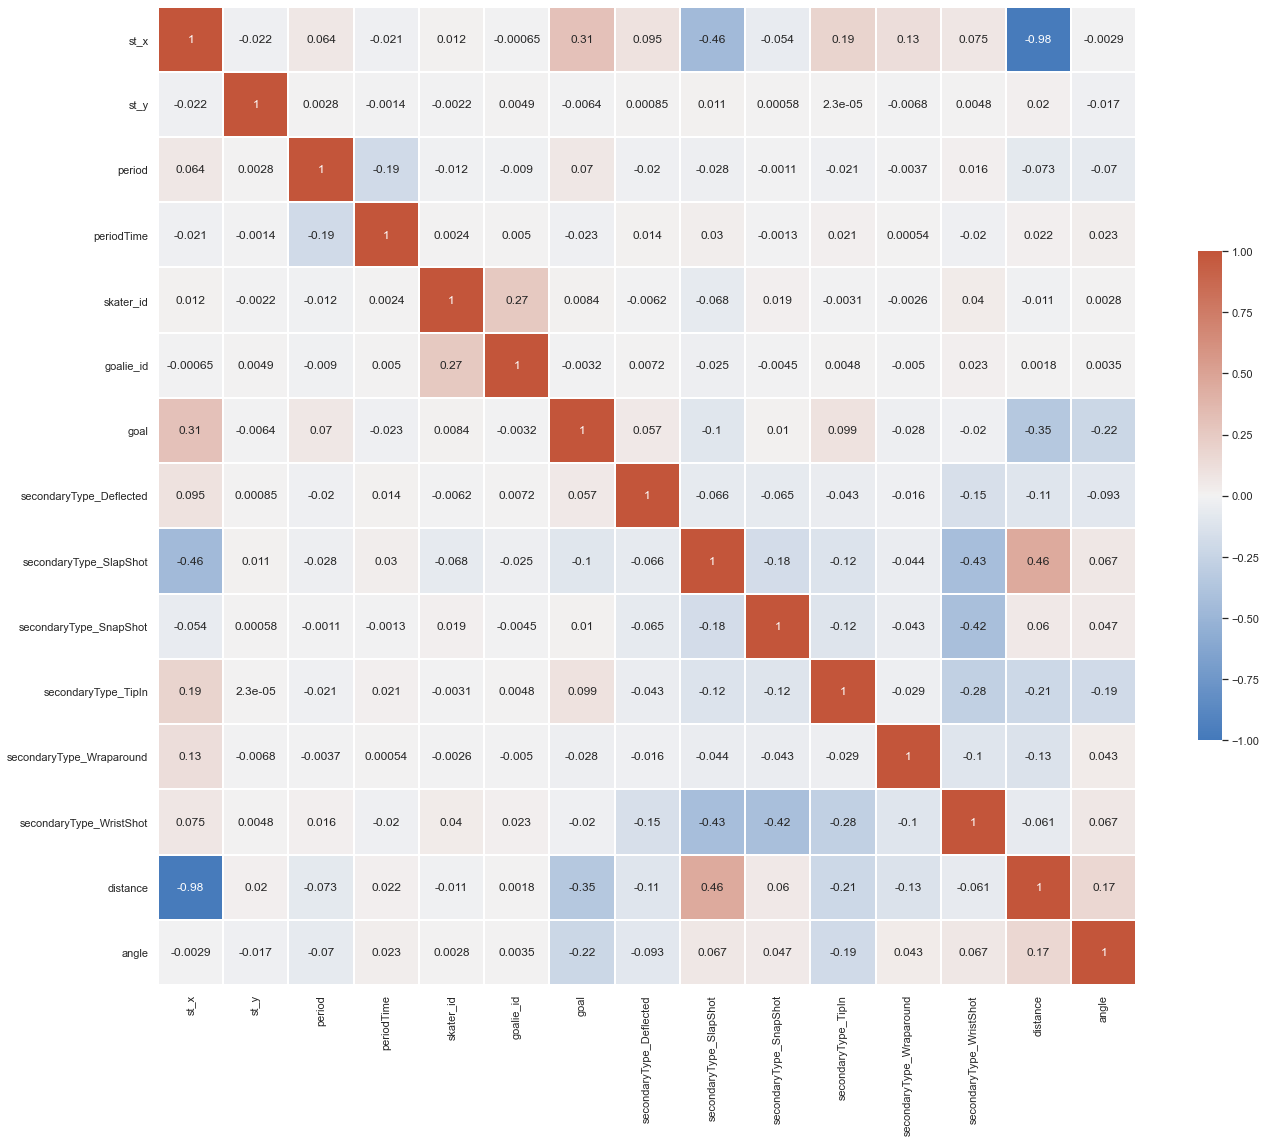

In [191]:
plot_correlation_matrix(df)

In [192]:
from sklearn.neighbors import KNeighborsClassifier
from utils import run_model

In [193]:
knn = KNeighborsClassifier(n_neighbors = 100)
_ = run_model(knn, df, features, target)

Training ran in 0.09792 seconds
Score: 0.5202463433410316
F1 Score: 0.56


In [194]:
features = ['distance']

target = 'goal'
model, X_test, y_test = run_logistic_regression(df, features, target)

Training ran in 0.07490 seconds
Score: 0.6560174493199897
F1 Score: 0.69


In [195]:
model.coef_

array([[-0.04478573]])

In [196]:
model.intercept_

array([1.71957452])

In [197]:
df.distance.min()

4.0

Text(0.5, 1.0, 'Logistic Regression Model for Shots')

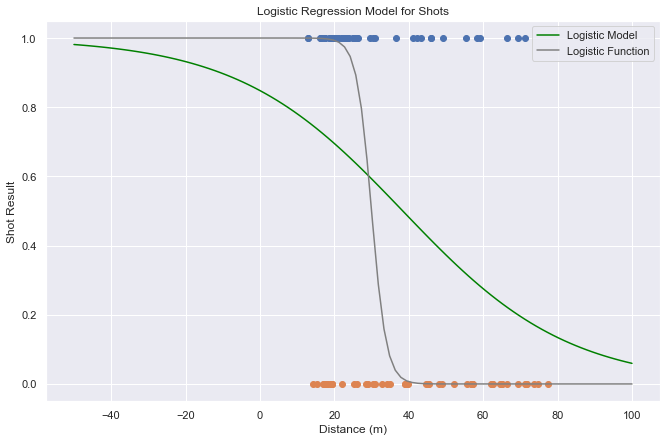

In [198]:
#compare this model to the sample data from before
df_goals = df[df.goal==1]
df_misses = df[df.goal==0]

fig, axes = plt.subplots(figsize=(11,7))
#goals = plt.scatter(df_log_goal['Distance'].head(100),df_log_goal['Goal'].head(100))
#misses = plt.scatter(df_log_miss['Distance'].head(100),df_log_miss['Goal'].head(100),marker='x')
plt.scatter(df_goals.distance.head(50),df_goals.goal.head(50))
plt.scatter(df_misses.distance.head(50),df_misses.goal.head(50))
y = np.linspace(-50,100,100)

plt.plot(y,1/(1+np.exp(-(model.coef_[0][0]*y+model.intercept_[0]))),c='Green',label='Logistic Model')
plt.plot(y,1/(1+np.exp(+(.5*y)-15)),c='grey',label='Logistic Function')

plt.xlabel('Distance (m)')
plt.ylabel('Shot Result')
plt.legend()
plt.title('Logistic Regression Model for Shots')

In [217]:
df_data_players = df.copy()

# Players

In [218]:
df_player_stats = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_player_stats.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [219]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')
df_player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


In [228]:
df_goalie = pd.read_csv('data/nhl/nhl_stats/game_goalie_stats.csv')
df_goalie = df_goalie.groupby('player_id').agg({'savePercentage':'mean'}).reset_index()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie                                                

,goalie_id,savePercentage
0,8445275,89.979639
1,8445386,89.914678
2,8445470,86.247964
3,8445769,90.347714
4,8446719,87.575872
...,...,...
363,8480263,50.000000
364,8480363,81.818182
365,8480382,90.448332
366,8480420,89.707548


In [229]:
df_skater = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_skater = df_skater.groupby('player_id').agg({'goals':'sum', 'shots':'sum', 'assists':'sum', 'timeOnIce':'sum'}).reset_index()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater

,skater_id,goals,shots,assists,timeOnIce
0,8444894,11,66,12,51806
1,8444919,4,174,37,232930
2,8445000,88,696,74,322029
3,8445176,59,532,82,214915
4,8445266,7,185,23,329428
...,...,...,...,...,...
3348,8481642,0,2,0,1788
3349,8481649,0,18,0,12652
3350,8481650,4,46,6,43936
3351,8481812,0,0,0,3894


In [233]:
df_merged = df.copy()

df_merged = df_merged.merge(df_skater, how='left', on='skater_id')
df_merged = df_merged.merge(df_goalie, how='left', on='goalie_id')

df_merged

,play_id,st_x,st_y,period,periodTime,skater_id,goalie_id,goal,secondaryType_Deflected,secondaryType_SlapShot,...,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,goals,shots,assists,timeOnIce,savePercentage
0,2016020045_6,88.0,-5.0,1,56,8474141.0,8473607.0,1,0,0,...,0,1,0,13.000000,22.619865,505,4185,815,1510638,90.093364
1,2016020045_97,76.0,-1.0,1,1046,8477929.0,8473607.0,1,0,0,...,0,0,0,24.020824,2.385944,10,143,12,89325,90.093364
2,2016020045_103,67.0,28.0,1,1092,8478550.0,8473607.0,1,0,1,...,0,0,0,43.278170,40.314100,224,1544,413,696850,90.093364
3,2016020045_140,83.0,-11.0,2,304,8466148.0,8473607.0,1,0,0,...,0,0,0,20.248457,32.905243,499,4143,606,1429420,90.093364
4,2016020045_197,76.0,11.0,2,1103,8476177.0,8470645.0,1,0,0,...,0,0,1,26.400758,24.623565,94,809,105,476023,91.021338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129893,2011021121_269,81.0,11.0,3,643,8467396.0,8468524.0,0,0,0,...,0,0,1,21.954498,30.068583,265,2052,267,931393,89.993024
129894,2013020944_300,47.0,20.0,3,763,8469465.0,8470140.0,0,0,1,...,0,0,0,56.648036,20.674425,61,1702,320,1635863,90.377574
129895,2014030311_36,82.0,18.0,1,355,8475167.0,8468685.0,0,0,0,...,0,0,0,25.455844,45.000000,159,2224,525,1451647,91.125365
129896,2018020921_63,39.0,-21.0,1,452,8474565.0,8475883.0,0,0,1,...,0,0,0,64.513564,18.996654,150,2548,471,1528016,90.623768


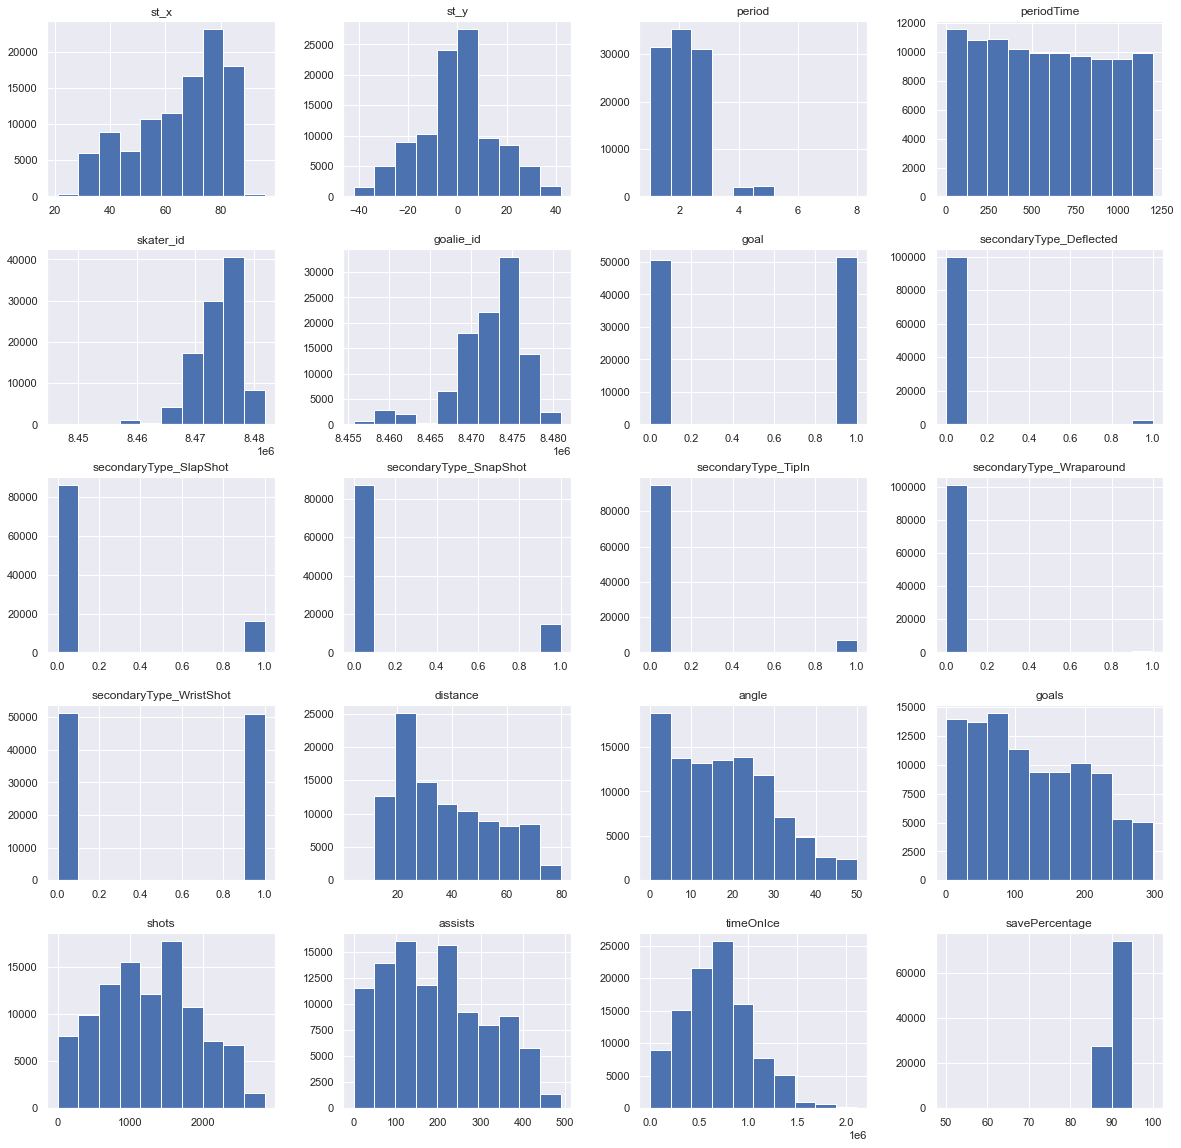

In [252]:
df_merged.hist(figsize=(20, 20));

In [261]:
df_merged = df_merged[df_merged.goals<300]
df_merged = df_merged[df_merged.shots<3000]
df_merged = df_merged[df_merged.assists<500]

df_merged = df_merged[df_merged.distance<30]
df_merged = df_merged[df_merged.angle<30]




In [262]:
df_merged.columns

Index(['play_id', 'st_x', 'st_y', 'period', 'periodTime', 'skater_id',
       'goalie_id', 'goal', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle', 'goals', 'shots',
       'assists', 'timeOnIce', 'savePercentage'],
      dtype='object')

In [271]:
features = ['st_x', 'st_y', 'period', 'periodTime', 'secondaryType_Deflected',
       'secondaryType_SlapShot', 'secondaryType_SnapShot',
       'secondaryType_TipIn', 'secondaryType_Wraparound',
       'secondaryType_WristShot', 'distance', 'angle', 'skater_id', 'goalie_id', 'goals',
       'shots', 'assists', 'timeOnIce', 'savePercentage']


#features = ['secondaryType_Wraparound','angle']


target = 'goal'

# function implemented in the utils.py
model, X_test, y_test = run_lightgbm_classifier(df_merged, features, target)

Training ran in 0.11690 seconds
Score: 0.6946842728965634
F1 Score: 0.82


F1 Score: 0.82


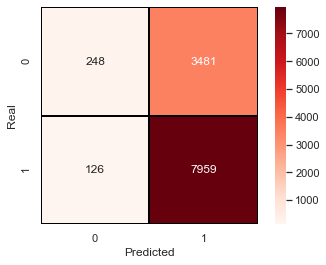

In [272]:
calculate_confusion_matrix(y_test, model.predict(X_test), plot=True);


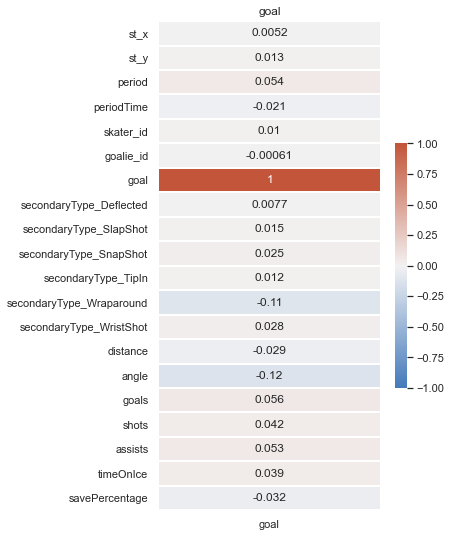

In [273]:
corr = df_merged.corr()
plt.subplots(figsize=(5, 9))
plt.title('goal')
cmap = sns.diverging_palette(250, 20, as_cmap=True)
sns.heatmap(corr[['goal']], cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});


In [274]:
from lightgbm import LGBMClassifier
import lightgbm

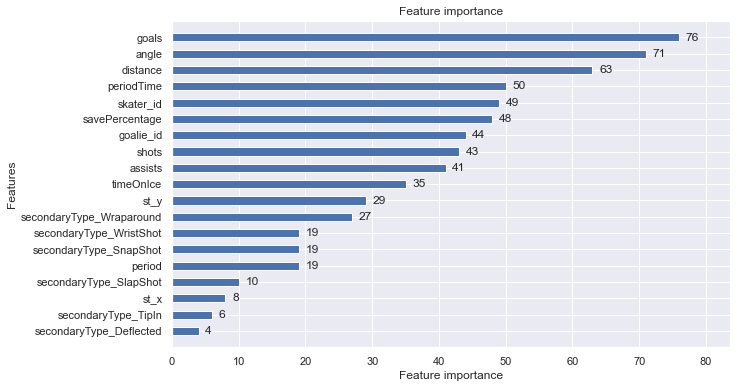

In [282]:
lightgbm.plot_importance(model, figsize=(10, 6), height=.5);

In [283]:
df_merged.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])


KeyError: 'firstName'

In [272]:
df_merged

,play_id,event,secondaryType,st_x,st_y,game_id,player_id,playerType,firstName,lastName,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,2016020045_5,Shot,WristShot,71.0,-9.0,2016020045,8473573,Shooter,Artem,Anisimov,...,54.0,4.2,1.4,5.6,2544.57,75.0,3.5,110.1,39.1,0.61
1,2016020045_6,Goal,Wraparound,88.0,-5.0,2016020045,8474141,Scorer,Patrick,Kane,...,91.0,8.7,2.1,10.8,3057.71,75.0,4.8,114.0,89.2,1.09
2,2016020045_8,Shot,WristShot,56.0,-7.0,2016020045,8474668,Shooter,Dale,Weise,...,41.0,0.2,1.1,1.3,2474.29,201.0,24.7,104.5,23.2,0.36
3,2016020045_12,Shot,SlapShot,37.0,24.0,2016020045,8470281,Shooter,Duncan,Keith,...,111.0,4.0,5.5,9.5,2774.72,147.0,7.0,112.4,54.0,0.67
4,2016020045_17,Shot,WristShot,57.0,-20.0,2016020045,8474190,Shooter,Wayne,Simmonds,...,117.0,5.1,1.2,6.3,3373.26,350.0,6.5,123.0,53.1,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766991,2018030417_277,Goal,SnapShot,77.0,-7.0,2018030417,8477482,Scorer,Zach,Sanford,...,27.0,0.1,0.5,0.7,1607.84,52.0,7.2,103.3,6.7,NaN
766992,2018030417_280,Shot,SnapShot,69.0,-7.0,2018030417,8470257,Shooter,Alexander,Steen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766993,2018030417_281,Shot,SnapShot,65.0,4.0,2018030417,8475158,Shooter,Ryan,O'Reilly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766994,2018030417_285,Shot,WristShot,42.0,3.0,2018030417,8475149,Shooter,Marcus,Johansson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [277]:
df_merged.describe()

,st_x,st_y,game_id,player_id,Salary,Ht,Wt,DftYr,DftRd,Ovrl,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
count,766996.000000,766996.000000,7.669960e+05,7.669960e+05,4.245800e+05,424580.000000,424580.000000,388988.000000,388988.000000,388988.000000,...,424579.000000,424580.000000,424580.000000,424580.000000,424579.000000,424580.000000,424580.000000,424579.000000,424579.000000,424348.000000
mean,59.383814,-0.112144,2.014665e+09,8.473261e+06,3.858017e+06,73.032604,202.229003,2007.325902,2.330581,54.048045,...,68.249157,2.655697,1.854593,4.513864,2677.453190,164.588991,9.511612,111.622432,38.065253,0.523855
std,22.722726,18.966417,2.883972e+06,4.017834e+03,2.815642e+06,2.047916,15.238167,4.445403,1.911238,62.381916,...,27.989834,2.520301,1.426991,3.150351,771.276395,93.474460,6.612249,6.607080,23.791131,0.296253
min,-99.000000,-42.000000,2.010020e+09,8.446485e+06,5.750000e+05,67.000000,160.000000,1990.000000,1.000000,1.000000,...,0.000000,-1.700000,-0.200000,-1.200000,33.510000,0.000000,0.000000,77.600000,-4.300000,-0.810000
25%,46.000000,-14.000000,2.012021e+09,8.470642e+06,1.000000e+06,72.000000,191.000000,2004.000000,1.000000,7.000000,...,53.000000,0.500000,0.900000,2.000000,2496.450000,101.000000,5.700000,107.100000,18.200000,0.290000
50%,63.000000,0.000000,2.015020e+09,8.474102e+06,3.667000e+06,73.000000,201.000000,2008.000000,1.000000,26.000000,...,71.000000,2.200000,1.600000,4.400000,2898.120000,141.000000,7.800000,111.800000,37.400000,0.540000
75%,77.000000,14.000000,2.017021e+09,8.476312e+06,5.600000e+06,74.000000,213.000000,2010.000000,3.000000,77.000000,...,89.000000,4.200000,2.200000,6.600000,3190.760000,222.000000,11.600000,116.300000,55.400000,0.730000
max,99.000000,42.000000,2.019041e+09,8.481813e+06,1.380000e+07,81.000000,265.000000,2016.000000,9.000000,279.000000,...,137.000000,10.500000,7.200000,12.900000,3527.100000,622.000000,61.000000,175.700000,99.200000,1.260000


In [280]:
df_player_stats[df_player_stats.lastName=='Sanford']

,Salary,Born,City,Pr/St,Cntry,nationality,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
178,875000,94-11-09,Salem,MA,USA,USA,76,203,2013.0,2.0,...,27.0,0.1,0.5,0.7,1607.84,52,7.2,103.3,6.7,NaN


In [283]:
df_merged.dropna(inplace=True)

In [285]:
df_merged.event.value_counts()

Shot    241963
Goal     25189
Name: event, dtype: int64

In [294]:
df_merged.drop(columns=['game_id', 'player_id', 'playerType', 'firstName', 'lastName', 'nationality', 'Born', 'City', 'Pr/St', 'Cntry'], inplace=True)

In [307]:
cat_var_cols = ['secondaryType', 'Hand', 'Position', 'Team']
df_data_play = create_dummy_df(df=df_merged, cat_cols=cat_var_cols, dummy_na=True)
#df_lst_data.drop(columns=['secondaryType_nan'], inplace=True)
df_data_play.head()

,play_id,event,st_x,st_y,Salary,Ht,Wt,DftYr,DftRd,Ovrl,...,Team_PIT/TOR,Team_S.J,Team_STL,Team_T.B,Team_T.B/TOR,Team_TOR,Team_VAN,Team_WPG,Team_WSH,Team_nan
1,2016020045_6,Goal,88.0,-5.0,13800000.0,71.0,177.0,2007.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2016020045_8,Shot,56.0,-7.0,2750000.0,74.0,206.0,2008.0,4.0,111.0,...,0,0,0,0,0,0,0,0,0,0
3,2016020045_12,Shot,37.0,24.0,6000000.0,73.0,192.0,2002.0,2.0,54.0,...,0,0,0,0,0,0,0,0,0,0
4,2016020045_17,Shot,57.0,-20.0,4300000.0,74.0,185.0,2007.0,2.0,61.0,...,0,0,0,0,0,0,0,0,0,0
5,2016020045_19,Shot,34.0,14.0,925000.0,71.0,180.0,2012.0,3.0,78.0,...,0,0,0,0,0,0,0,0,0,0


In [308]:
df_data_play['goal'] = np.where(df_data_play.event=='Goal', 1, 0)
df_data_play.drop(columns='event', inplace=True)
df_data_play.head()

,play_id,st_x,st_y,Salary,Ht,Wt,DftYr,DftRd,Ovrl,GP,...,Team_S.J,Team_STL,Team_T.B,Team_T.B/TOR,Team_TOR,Team_VAN,Team_WPG,Team_WSH,Team_nan,goal
1,2016020045_6,88.0,-5.0,13800000.0,71.0,177.0,2007.0,1.0,1.0,82.0,...,0,0,0,0,0,0,0,0,0,1
2,2016020045_8,56.0,-7.0,2750000.0,74.0,206.0,2008.0,4.0,111.0,64.0,...,0,0,0,0,0,0,0,0,0,0
3,2016020045_12,37.0,24.0,6000000.0,73.0,192.0,2002.0,2.0,54.0,80.0,...,0,0,0,0,0,0,0,0,0,0
4,2016020045_17,57.0,-20.0,4300000.0,74.0,185.0,2007.0,2.0,61.0,82.0,...,0,0,0,0,0,0,0,0,0,0
5,2016020045_19,34.0,14.0,925000.0,71.0,180.0,2012.0,3.0,78.0,76.0,...,0,0,0,0,0,0,0,0,0,0


In [309]:
df_data_cols = df_data_play.select_dtypes(include=['float64', 'int64', 'uint8']).copy()

In [310]:
df_data_cols

,st_x,st_y,Salary,Ht,Wt,DftYr,DftRd,Ovrl,GP,G,...,Team_S.J,Team_STL,Team_T.B,Team_T.B/TOR,Team_TOR,Team_VAN,Team_WPG,Team_WSH,Team_nan,goal
1,88.0,-5.0,13800000.0,71.0,177.0,2007.0,1.0,1.0,82.0,34.0,...,0,0,0,0,0,0,0,0,0,1
2,56.0,-7.0,2750000.0,74.0,206.0,2008.0,4.0,111.0,64.0,8.0,...,0,0,0,0,0,0,0,0,0,0
3,37.0,24.0,6000000.0,73.0,192.0,2002.0,2.0,54.0,80.0,6.0,...,0,0,0,0,0,0,0,0,0,0
4,57.0,-20.0,4300000.0,74.0,185.0,2007.0,2.0,61.0,82.0,31.0,...,0,0,0,0,0,0,0,0,0,0
5,34.0,14.0,925000.0,71.0,180.0,2012.0,3.0,78.0,76.0,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766982,32.0,-18.0,925000.0,78.0,226.0,2012.0,3.0,86.0,81.0,4.0,...,0,1,0,0,0,0,0,0,0,0
766983,80.0,19.0,5000000.0,69.0,181.0,2006.0,3.0,71.0,80.0,39.0,...,0,0,0,0,0,0,0,0,0,0
766986,67.0,-3.0,6000000.0,73.0,195.0,2009.0,1.0,5.0,79.0,25.0,...,0,0,0,0,0,0,0,0,0,1
766988,60.0,23.0,767500.0,73.0,185.0,2014.0,4.0,116.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
# taking all goals and a sample with the same size from shot without a goal
goals = df_data_cols[df_data_cols.goal==1]
no_goals = df_data_cols[df_data_cols.goal==0].sample(goals.shape[0], replace=False)
df_data = pd.concat([goals, no_goals])

<AxesSubplot:>

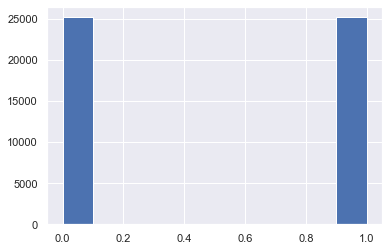

In [313]:
df_data.goal.hist()

In [325]:
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data['distance'] = df_data.apply(dist, axis=1)

In [335]:
corr = df_data.corr()

In [337]:
# target is the price
y_target_col = 'goal'
# Create a ranking of features correlated (+/-) with the target
relevant_features = np.abs(df_data.corr()[y_target_col]).sort_values(ascending=False)

#remove columns with NaN relevancy and the target
relevant_features = relevant_features[~relevant_features.isnull()].drop(index=y_target_col)

In [345]:
df_data[relevant_features[:10].index].columns

Index(['distance', 'st_x', 'sDist.1', 'Position_D', 'sDist', 'iSCF', 'BLK%',
       'G', 'ixG', 'IPP%'],
      dtype='object')

In [347]:
# use just 3 most correlated features
features = ['distance', 'st_x'] #, 'sDist.1', 'Position_D', 'sDist', 'iSCF', 'BLK%', 'G', 'ixG', 'IPP%']
target = 'goal'

X_test, y_test, model, score = run_logistic_regression(df_data, features, target)

f1, _ = calculate_confusion_matrix(y_test, model.predict(X_test));
print(f'F1-score: {f1}')

Score: 0.660844250363901
F1-score: 0.6849028768133759
